<a href="https://colab.research.google.com/github/st-sashou/ai_experimental/blob/master/feature_importance_accuracy_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ランダムフォレストによる特徴量の重要度の算出
説明変数を**Axxx～Bxxx**、目的変数を**年収**とする。  
年収に与える各説明変数の影響度を算出することとする。

## アンケートデータの読み込み

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_survey.pkl'
df_survey = pd.read_pickle(INPUT_FILE)
df_survey = df_survey.loc[:, ['survey_number', 'question']].set_index('survey_number')
df_survey.head()

,question
survey_number,
P001,月間の労働時間は１６０時間を超えていますか？
P002,あなたの生まれた年を教えてください
P003,あなたの性別を教えてください
P004,あなたの身長を教えてください
P005,あなたの体重を教えてください


In [3]:
INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_answer.pkl'
df = pd.read_pickle(INPUT_FILE)
df = df.set_index('respondent_id')
df.head()

,annual_income,A002,A003,A004,A005,A006,A008,A009,A010,A011,...,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010
respondent_id,,,,,,,,,,,,,,,,,,,,,
399534,550,False,True,False,False,False,True,True,False,False,...,True,1976,"""男性""",175,64.0,40,70,0,"""事務""","""係長・主任"""
488842,120,True,True,True,False,True,True,True,False,True,...,True,1980,"""男性""",177,64.4,10,0,0,"""サービス""","""その他専門職・特別職等"""
515662,260,False,False,False,True,False,False,False,False,True,...,True,1983,"""女性""",156,48.0,20,20,0,"""営業・販売""","""係長・主任"""
890958,96,True,False,True,False,True,False,True,False,False,...,True,1974,"""女性""",158,72.6,8,0,0,"""その他""","""その他専門職・特別職等"""
1227044,292,True,False,True,False,True,True,True,False,False,...,True,1986,"""女性""",157,49.0,21,40,0,"""その他""","""一般社員"""


## 事前処理

In [0]:
columns = df.columns
columns = pd.Series(columns[columns.str.startswith('A') | columns.str.startswith('B')].sort_values(ascending=True))

X = df.loc[:, columns].astype('float')
X.loc[:, columns.str.startswith('B').values] *= -1
X.loc[:, columns.str.startswith('B').values] += 1
Y = df[df.loc[:, columns[columns.str.startswith('A')]]].count(axis=1) + \
        df[df.loc[:, columns[columns.str.startswith('B')]] == False].count(axis=1)

In [5]:
X.head()

,A002,A003,A004,A005,A006,A008,A009,A010,A011,A013,...,B704,B705,B706,B707,B708,B709,B710,B711,B712,B713
respondent_id,,,,,,,,,,,,,,,,,,,,,
399534,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
488842,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
515662,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
890958,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1227044,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
Y.head()

respondent_id
399534     561
488842     556
515662     596
890958     516
1227044    537
dtype: int64

## ランダムフォレストオブジェクトによる重要度の抽出

### オブジェクトの生成とモデルの適合

In [7]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, random_state=1)
forest.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

### 重要度の表示



*   number: アンケート番号
*   importance: 重要度 (0≦importance≦1)
*   question: アンケート文



In [8]:
import numpy as np

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("   %-*s %-*s %s" % (8, 'number', 12, 'importance', 'question'))
for f in range(X.shape[1]):
    print("%2d) %-*s %-*f %s" %
            (f + 1, 8, columns[indices[f]], 10, importances[indices[f]], df_survey.at[columns[indices[f]], 'question']))

   number   importance   question
 1) A824     0.075875   栄養バランスの良い食事をとっていますか？
 2) A743     0.071268   週に１回以上、青魚を食べるようにしていますか？
 3) B102     0.063023   人よりも疲れやすいほうですか？
 4) A239     0.049571   週に１回以上、具だくさんの味噌汁を飲んでいますか？
 5) A055     0.028708   長時間、スマートフォンを使用しないようにしていますか？
 6) A850     0.017903   毎日、緑黄色野菜を食べていますか？
 7) A787     0.017080   ラーメン、牛丼、パスタなど、一皿ものだけの食事を控えるようにしていますか？
 8) A703     0.016514   ラーメンやパスタ、うどん、そば、焼きそばなどの、麺類のみで食事を済ませないようにしていますか？
 9) B064     0.016149   人よりも気持ちが落ち込むことは多いですか？
10) B675     0.015625   直近１ヶ月間は、寝つきが悪かったですか？
11) B548     0.014450   直近１ヶ月間は、ストレスを感じやすいですか？
12) B478     0.010063   直近１ヶ月間は、気持ちが落ち込みやすかったですか？
13) B101     0.009616   人よりも疲れが取れにくいほうですか？
14) A346     0.008438   週に１回以上、しらすを食べていますか？
15) B469     0.008300   直近１ヶ月間は、イライラしやすかったですか？
16) A746     0.008037   週に１回以上、焼き魚を食べるようにしていますか？
17) A786     0.007600   携帯電話で通話するときには、イヤフォンマイクを使うようにしていますか？
18) B586     0.007598   直近１ヶ月間は、疲れやすかったですか？
19) A667     0.006873   体を冷やさないような生活をおくっていますか？
20) A435     0.006234   週に１回以上、生の

### 上位100問までの重要度のグラフ

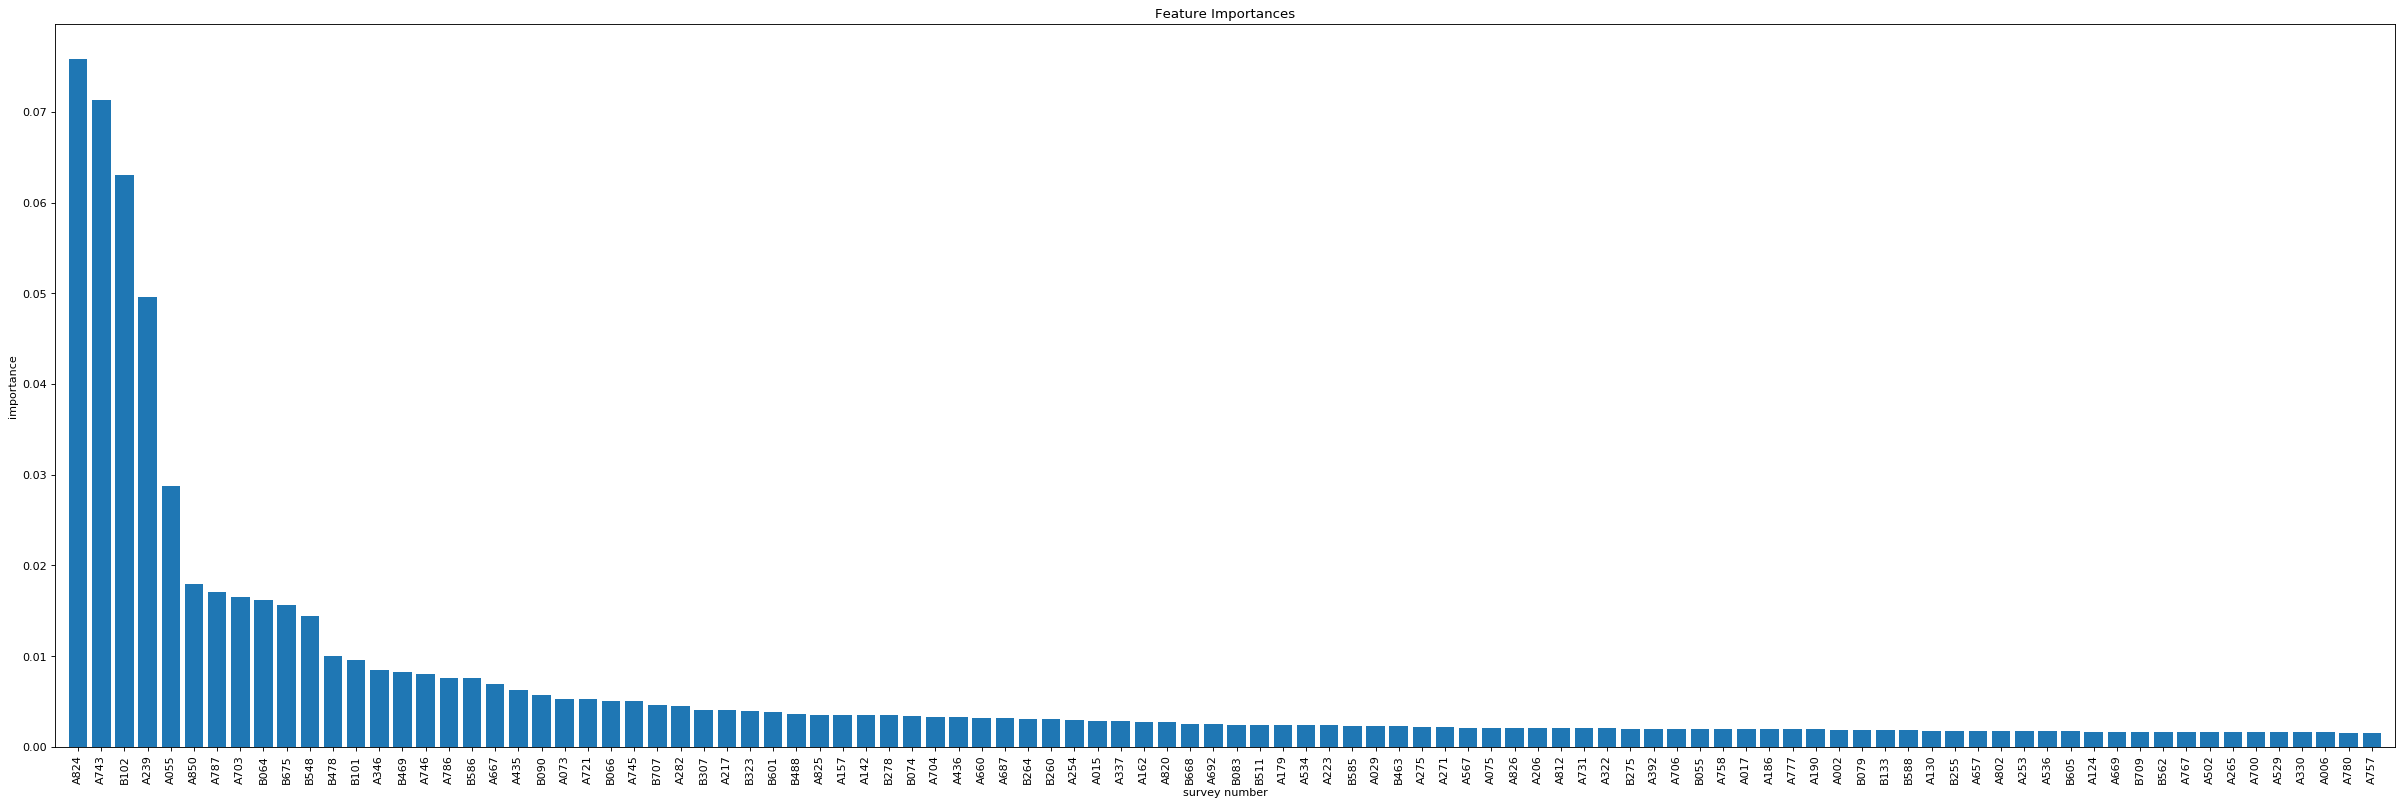

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10), dpi=80)
plt.title('Feature Importances')
plt.bar(range(100), importances[indices[0:100]], align='center')
plt.xticks(range(100), columns[indices[0:100]], rotation=90)
plt.xlim([-1, 100])
plt.tight_layout()
plt.xlabel('survey number')
plt.ylabel('importance')
plt.show()